### Import libraries

In [2]:
!pip install datasets evaluate nltk sentence-transformers detoxify

import torch
from torch.utils.data import DataLoader, Dataset
from transformers import T5ForConditionalGeneration, T5Tokenizer, AdamW
from torch.cuda.amp import autocast, GradScaler
import logging
import os
import matplotlib.pyplot as plt
import evaluate
import numpy as np
from sentence_transformers import SentenceTransformer
from detoxify import Detoxify
from datasets import load_dataset as hf_load_dataset
import pandas as pd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.2 MB/s eta 0:00:00


### **File 1: dataset.py**

In [3]:
def read_dataset(tsv_path: str):
    dataset = hf_load_dataset("csv", data_files=tsv_path, delimiter="\t", split="train")
    return dataset

class DetoxificationDataset(Dataset):
    def __init__(self, hf_dataset, tokenizer, max_length: int = 128):
        self.dataset = hf_dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        toxic_text = item["toxic"]
        neutral_text = item.get("neutral1") or item.get("neutral2") or item.get("neutral3")
        prompt = "detoxify text: "
        toxic_text_with_prompt = prompt + toxic_text

        input_encodings = self.tokenizer(
            toxic_text_with_prompt,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        target_encodings = self.tokenizer(
            neutral_text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        
        input_ids = input_encodings["input_ids"].squeeze()
        attention_mask = input_encodings["attention_mask"].squeeze()
        labels = target_encodings["input_ids"].squeeze()
        labels[labels == self.tokenizer.pad_token_id] = -100
        
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
            "toxic_text": toxic_text
        }

def split_dataset(tsv_path: str, eval_size: int = 1962, seed: int = 42):
    full_dataset = read_dataset(tsv_path)
    dataset_len = len(full_dataset)
    if dataset_len < eval_size:
        raise ValueError("Dataset has fewer samples than the requested evaluation size.")
    eval_fraction = eval_size / dataset_len
    splits = full_dataset.train_test_split(test_size=eval_fraction, seed=seed)
    return splits["train"], splits["test"]

def create_dataloader(tsv_path: str, tokenizer, batch_size: int = 16, max_length: int = 128, seed: int = 42, eval_size: int = 1962):
    train_dataset, eval_dataset = split_dataset(tsv_path, eval_size=eval_size, seed=seed)
    train_data = DetoxificationDataset(train_dataset, tokenizer, max_length)
    eval_data = DetoxificationDataset(eval_dataset, tokenizer, max_length)
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    eval_dataloader = DataLoader(eval_data, batch_size=batch_size, shuffle=False)
    return train_dataloader, eval_dataloader

### **File 2: logging_utils.py**

In [4]:
def setup_logger(log_file: str = "training.log"):
    logger = logging.getLogger("training_logger")
    logger.setLevel(logging.INFO)
    if logger.hasHandlers():
        logger.handlers.clear()
    fh = logging.FileHandler(log_file)
    fh.setLevel(logging.INFO)
    ch = logging.StreamHandler()
    ch.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    fh.setFormatter(formatter)
    ch.setFormatter(formatter)
    logger.addHandler(fh)
    logger.addHandler(ch)
    return logger

def log_metrics(logger, step: int, metrics: dict):
    message = f"Step {step}: " + ", ".join([f"{key}: {value:.4f}" for key, value in metrics.items()])
    logger.info(message)

def plot_metric(metric_values: list, metric_name: str, save_dir: str = None):
    plt.figure(figsize=(8, 6))
    plt.plot(metric_values, marker='o', linestyle='-', color='b')
    plt.title(f"{metric_name} over Training Steps")
    plt.xlabel("Step/Epoch")
    plt.ylabel(metric_name)
    plt.grid(True)
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f"{metric_name}_plot.png")
        plt.savefig(save_path)
        print(f"Saved {metric_name} plot to {save_path}")
    plt.show()

def plot_losses(train_losses: list, eval_losses: list, save_dir: str = None):
    plt.figure(figsize=(8, 6))
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, marker='o', linestyle='-', label="Training Loss", color='r')
    plt.plot(epochs, eval_losses, marker='o', linestyle='-', label="Evaluation Loss", color='g')
    plt.title("Training and Evaluation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, "loss_plot.png")
        plt.savefig(save_path)
        print(f"Saved loss plot to {save_path}")
    plt.show()

### **File 3: split_dataset.py**

In [5]:
def split_tsv(input_file, train_file, eval_file, eval_size=1962, random_seed=42):
    df = pd.read_csv(input_file, sep="\t")
    eval_df = df.sample(n=eval_size, random_state=random_seed)
    train_df = df.drop(eval_df.index)
    train_df.to_csv(train_file, sep="\t", index=False)
    eval_df.to_csv(eval_file, sep="\t", index=False)
    print(f"Saved {len(train_df)} training samples to {train_file}")
    print(f"Saved {len(eval_df)} evaluation samples to {eval_file}")

### **File 4: model.py**

In [6]:
def load_t5(model_name: str = "t5-base"):
    tokenizer = T5Tokenizer.from_pretrained(model_name)
    model = T5ForConditionalGeneration.from_pretrained(model_name)
    model.config.dropout_rate = 0.15
    return model, tokenizer

### **File 5: metrics.py**

In [7]:
!pip install sacrebleu
# Latest version of nltk
!pip install -U nltk
from sentence_transformers import util

bleu = evaluate.load("sacrebleu")
meteor = evaluate.load("meteor")

def compute_bleu(predictions, references):
    results = bleu.compute(predictions=predictions, references=[[ref] for ref in references])
    return results["score"]

def compute_meteor(predictions, references):
    results = meteor.compute(predictions=predictions, references=references)
    return results["meteor"]

def compute_content_preservation(original_texts, generated_texts, embedding_model=None):
    if embedding_model is None:
        embedding_model = SentenceTransformer("paraphrase-MiniLM-L6-v2")
    orig_embeddings = embedding_model.encode(original_texts, convert_to_tensor=True)
    gen_embeddings = embedding_model.encode(generated_texts, convert_to_tensor=True)
    cosine_scores = util.cos_sim(orig_embeddings, gen_embeddings)
    diag_sim = cosine_scores.diag().cpu().numpy()
    return np.mean(diag_sim)

def compute_all_metrics(predictions, references, original_texts=None):
    metrics = {}
    metrics["bleu"] = compute_bleu(predictions, references)
    metrics["meteor"] = compute_meteor(predictions, references)
    if original_texts is not None:
        metrics["content_preservation"] = compute_content_preservation(original_texts, predictions)
    else:
        metrics["content_preservation"] = None
    return metrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 19.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.1 which is incompatible.


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


### **Training and Evaluation**

### Setup Logger

In [8]:
logger = setup_logger("/kaggle/working/training.log")

### Load model and tokenizer

In [9]:
model, tokenizer = load_t5("t5-base")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

### Load data

In [10]:
tsv_path = "/kaggle/input/paradetox/paradetox.tsv"
train_loader, eval_loader = create_dataloader(tsv_path, tokenizer, 
                                              batch_size=16, max_length=128, eval_size=1962)

Generating train split: 0 examples [00:00, ? examples/s]

### Optimizer and scaler

In [11]:
optimizer = AdamW(model.parameters(), lr=5e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Training Loop

In [12]:
from transformers import get_linear_schedule_with_warmup

num_epochs = 5
train_losses = []
eval_losses = []
bleu_scores = []
meteor_scores = []
content_preservation_scores = []
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.2 * total_steps), num_training_steps=total_steps)

best_eval_loss = float('inf')
# Stop if eval loss increases for 1 epoch
patience = 2
patience_counter = 0
best_model_path = "/kaggle/working/t5_detox_model_best"

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        # Gradient Clip
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        scheduler.step()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    eval_loss = 0
    predictions = []
    references = []
    original_texts = []
    with torch.no_grad():
        for batch in eval_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            eval_loss += outputs.loss.item()
            
            preds = model.generate(input_ids=input_ids, attention_mask=attention_mask,
                                   max_length=128, num_beams=4, early_stopping=True)
            pred_texts = [tokenizer.decode(p, skip_special_tokens=True) for p in preds]
            ref_texts = [tokenizer.decode(l[(l != tokenizer.pad_token_id) & (l != -100)], 
                                          skip_special_tokens=True) for l in labels]
            orig_texts = batch["toxic_text"]
            
            predictions.extend(pred_texts)
            references.extend(ref_texts)
            original_texts.extend(orig_texts)
    
    avg_eval_loss = eval_loss / len(eval_loader)
    eval_losses.append(avg_eval_loss)
    
    # Compute metrics
    metrics = compute_all_metrics(predictions, references, original_texts)
    bleu_scores.append(metrics["bleu"])
    meteor_scores.append(metrics["meteor"])
    content_preservation_scores.append(metrics["content_preservation"])
    log_metrics(logger, epoch + 1, {"train_loss": avg_train_loss, 
                                    "eval_loss": avg_eval_loss, **metrics})

    # Early stopping
    if avg_eval_loss < best_eval_loss:
        best_eval_loss = avg_eval_loss
        patience_counter = 0
        # Save best model
        model.save_pretrained(best_model_path)
        tokenizer.save_pretrained(best_model_path)
        print(f"Saved best model at epoch {epoch+1} with eval loss {best_eval_loss:.4f}")
    else:
        patience_counter += 1
        print(f"Eval loss increased. Patience counter: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.51k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/62 [00:00<?, ?it/s]

Batches:   0%|          | 0/62 [00:00<?, ?it/s]

2025-03-31 00:13:37,293 - INFO - Step 1: train_loss: 1.3903, eval_loss: 0.9571, bleu: 53.9908, meteor: 0.7545, content_preservation: 0.9073


Saved best model at epoch 1 with eval loss 0.9571


Batches:   0%|          | 0/62 [00:00<?, ?it/s]

Batches:   0%|          | 0/62 [00:00<?, ?it/s]

2025-03-31 00:27:05,165 - INFO - Step 2: train_loss: 0.9662, eval_loss: 0.8934, bleu: 55.2601, meteor: 0.7622, content_preservation: 0.8885


Saved best model at epoch 2 with eval loss 0.8934


Batches:   0%|          | 0/62 [00:00<?, ?it/s]

Batches:   0%|          | 0/62 [00:00<?, ?it/s]

2025-03-31 00:40:28,691 - INFO - Step 3: train_loss: 0.8817, eval_loss: 0.8860, bleu: 55.3429, meteor: 0.7637, content_preservation: 0.8858


Saved best model at epoch 3 with eval loss 0.8860


Batches:   0%|          | 0/62 [00:00<?, ?it/s]

Batches:   0%|          | 0/62 [00:00<?, ?it/s]

2025-03-31 00:53:51,439 - INFO - Step 4: train_loss: 0.8318, eval_loss: 0.8831, bleu: 55.5083, meteor: 0.7639, content_preservation: 0.8809


Saved best model at epoch 4 with eval loss 0.8831


Batches:   0%|          | 0/62 [00:00<?, ?it/s]

Batches:   0%|          | 0/62 [00:00<?, ?it/s]

2025-03-31 01:07:13,136 - INFO - Step 5: train_loss: 0.8056, eval_loss: 0.8806, bleu: 55.3634, meteor: 0.7612, content_preservation: 0.8798


Saved best model at epoch 5 with eval loss 0.8806


### Plot losses

Saved loss plot to /kaggle/working/plots/loss_plot.png


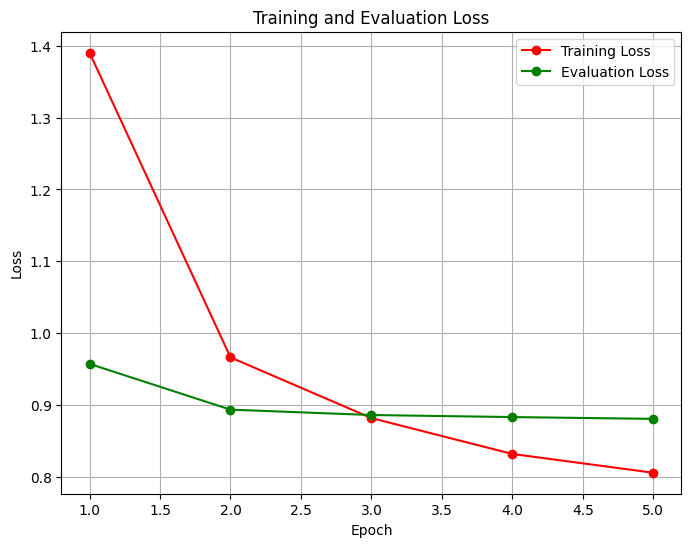

In [14]:
plot_losses(train_losses, eval_losses, save_dir="/kaggle/working/plots")

### Plot metrics

Saved BLEU plot to /kaggle/working/plots/BLEU_plot.png


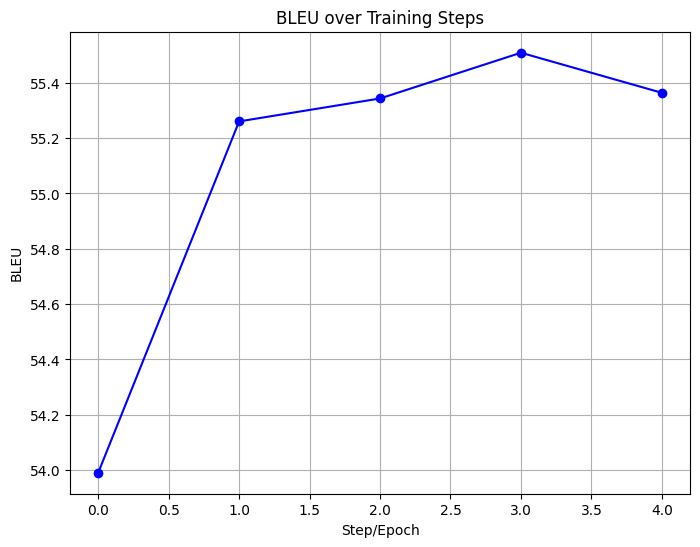

Saved METEOR plot to /kaggle/working/plots/METEOR_plot.png


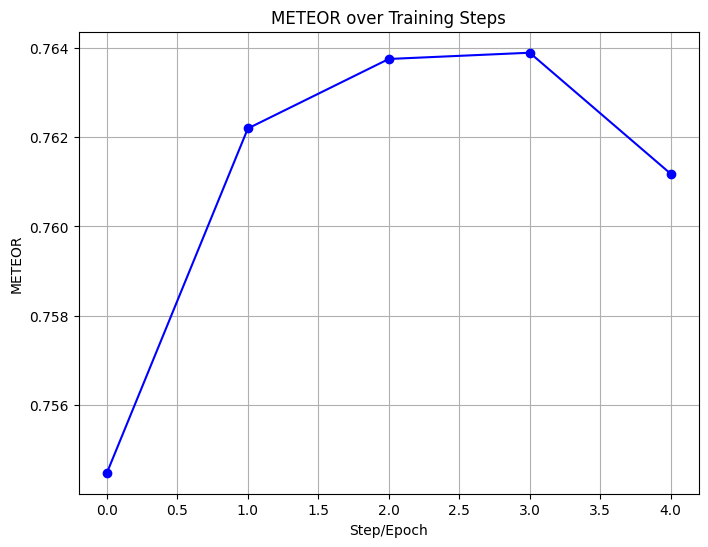

Saved Content Preservation plot to /kaggle/working/plots/Content Preservation_plot.png


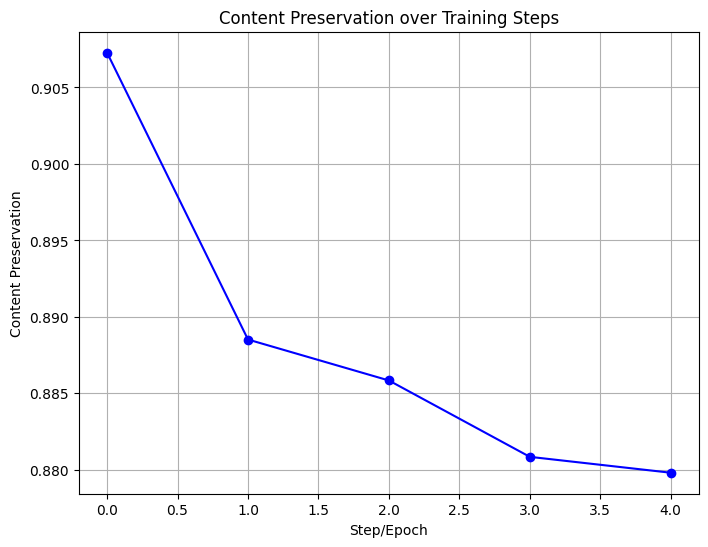

In [15]:
plot_metric(bleu_scores, "BLEU", save_dir="/kaggle/working/plots")
plot_metric(meteor_scores, "METEOR", save_dir="/kaggle/working/plots")
plot_metric(content_preservation_scores, "Content Preservation", save_dir="/kaggle/working/plots")

### Test

In [16]:
model.eval()
test_predictions = []
test_references = []
test_originals = []
with torch.no_grad():
    for i, batch in enumerate(eval_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        preds = model.generate(input_ids=input_ids, attention_mask=attention_mask, 
                               max_length=128, num_beams=4, early_stopping=True)
        pred_texts = [tokenizer.decode(p, skip_special_tokens=True) for p in preds]
        ref_texts = [tokenizer.decode(l[(l != tokenizer.pad_token_id) & (l != -100)], 
                                      skip_special_tokens=True) for l in labels]
        orig_texts = batch["toxic_text"]
        
        test_predictions.extend(pred_texts)
        test_references.extend(ref_texts)
        test_originals.extend(orig_texts)
        
        # Stop after collecting a few samples for display
        if len(test_predictions) >= 5:
            break

### Overall test BLEU & Sample display

In [17]:
test_metrics = compute_all_metrics(test_predictions, test_references, test_originals)
print("\nTest Set Metrics:")
log_metrics(logger, step="Final Test", metrics=test_metrics)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-31 01:07:19,531 - INFO - Step Final Test: bleu: 59.7066, meteor: 0.7999, content_preservation: 0.9018



Test Set Metrics:


In [18]:
print("\nTest Samples:")
for i in range(5):
    pred = test_predictions[i]
    ref = test_references[i]
    orig = test_originals[i]
    bleu_score = compute_bleu([pred], [ref])
    print(f"\nSample {i + 1}:")
    print(f"Original: {orig}")
    print(f"Predicted: {pred}")
    print(f"Reference: {ref}")
    print(f"BLEU: {bleu_score:.4f}")


Test Samples:

Sample 1:
Original: ya wikipedia sux ass they deleted my pic .
Predicted: they deleted my pic .
Reference: Wikipedia deleted my picture
BLEU: 21.3644

Sample 2:
Original: how the fuck do these parrots think that this scandal has anything to do with democrats ?
Predicted: How do these parrots think that this scandal has anything to do with democrats?
Reference: How do these people think that this scandal has anything to do with democrats?
BLEU: 80.0320

Sample 3:
Original: more like a pistol - fuck .
Predicted: More like a pistol
Reference: More like a pistol
BLEU: 100.0000

Sample 4:
Original: amazing that the gm moderators wont even allow the language that this lying reprobate used .
Predicted: amazing that the gm moderators wont even allow the language that this person used .
Reference: amazing that the gm moderators wont even allow the language that this lying reprobate used .
BLEU: 77.1079

Sample 5:
Original: ima be on my ass drunk .
Predicted: Ima be drunk.
Refere